#### Exploration of ozone pollution levels in 2015 and 2016

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np
import json
from datetime import datetime
from datetime import date
from datetime import timedelta
from sklearn.cluster import KMeans
import re
import json
import locale
import itertools

The data and variables:
    
- Air quality as measured by O3 levels
- Meteorological data
- Air pressure data
- Data about cars with Hologram 00 being allowed to circulate or not

In [2]:
months_choices = []
for i in range(1,13):
    months_choices.append((i, date(2008, i, 1).strftime('%B')))

## Days with prohibitions for using newer / lower emissions cars

In [3]:
with open("data/raw/hoy_no_circula.json", "r") as f:
    days1 = json.load(f)
    
with open("data/raw/hoy_no_circula_2.json", "r") as f:
    days2 = json.load(f)

In [4]:
def convert_date(s):
    day = re.findall(r'(\d+)-', s)[0]
    month = re.findall(r'-(\D+)-', s)[0]
    year = re.findall(r'-(\d{4})', s)[0]
    date = datetime.strptime("{}-{}-{}".format(day.zfill(2), month, year), "%d-%B-%Y")
    return date

In [5]:
days_all = {}

old_loc = locale.getlocale(locale.LC_TIME)
locale.setlocale(locale.LC_TIME, 'es_ES')
for k, v in days1.items():
    days_all[convert_date(k)] = v
    
for k, v in days2.items():
    days_all[convert_date(k)] = v
    
locale.setlocale(locale.LC_TIME, old_loc)

'C'

In [6]:
days_df = pd.DataFrame(index = [i for i in range(1, 32)])
days_df['January'] = ['' for i in range (1, 32)]
days_df['February'] = ['' for i in range (1, 32)]
days_df['March'] = ['' for i in range (1, 32)]
days_df['April'] = ['' for i in range (1, 32)]
days_df['May'] = ['' for i in range (1, 32)]
days_df['June'] = ['' for i in range (1, 32)]

In [7]:
for k, v in days_all.items():
    day = k.day
    month = datetime.strftime(k, "%B")
    year = k.year
    if year == 2016:
        days_df.set_value(day, month, v)

In [8]:
def count_restrictions(s):
    if re.search(r'\d y \d\n', s):
        return 1.0
    elif re.search(r'\d\sy\s\d{2}\sy\s\d', s):
        return 2.0
    else:
        return 0.0

In [9]:
days_df = days_df.applymap(count_restrictions)

In [10]:
days_df.set_value(31, 'June', np.nan)
days_df.set_value(31, 'April', np.nan)
days_df.set_value(31, 'February', np.nan)
days_df.set_value(30, 'February', np.nan)
days_df.head(1)

,January,February,March,April,May,June
1,0.0,0.0,0.0,0.0,0.0,2.0


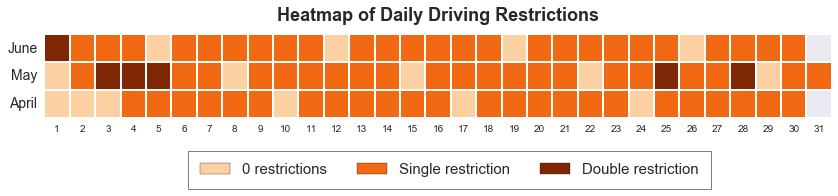

In [143]:
grid_kws = {'width_ratios': (0.9, 0.02), 'wspace': 0.08}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(15,1.5))
cmap = ListedColormap(['#fdd0a2','#f16913','#7f2704'])
ax = sns.heatmap(days_df[['June', 'May', 'April']].T, linewidths=1, cmap=cmap, ax=ax, cbar_ax=cbar_ax)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=14)
#cbar_ax.set_yticklabels(['0', '1', '2'])
#cbar_ax.yaxis.set_ticks([ 0.16666667, 0.5, 0.83333333])
cbar_ax.set_visible(False)
plt.yticks(rotation=0, fontsize=14)
ttl = ax.set_title("Heatmap of Daily Driving Restrictions", fontsize=18, weight='bold')
ttl.set_position([.5, 1.1])

p1 = patches.Rectangle((0, 0), 1, 1, fc='#fdd0a2')
p2 = patches.Rectangle((0, 0), 1, 1, fc='#f16913')
p3 = patches.Rectangle((0, 0), 1, 1, fc='#7f2704')
leg = fig.legend((p1, p2, p3), ('0 restrictions', 'Single restriction', 'Double restriction'), ncol=5,frameon=True, loc = 'lower center', bbox_to_anchor = (0,-0.6,1,1),
            bbox_transform = plt.gcf().transFigure, fontsize=15, borderpad=0.8)
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('white')

plt.savefig("img/pol1_restrictions.png", bbox_inches='tight')

## Exporation of Air Quality Data as Measured by ozone levels

In [150]:
aq_15 = pd.read_json('data/cleaned/contaminantes_2015_sm_O3.json').sort_values(by='date')
aq_15 = aq_15.replace('', np.nan)

In [151]:
aq_16 = pd.read_json('data/cleaned/contaminantes_2016_sm_O3.json').sort_values(by='date')
aq_16 = aq_16.replace('', np.nan)

In [152]:
# Find stations that existed in both 2015 and 2016
stat_15 = aq_15.columns.tolist()
stat_15.remove('date')
stat_15 = set(stat_15)
stat_16 = aq_16.columns.tolist()
stat_16.remove('date')
stat_16 = set(stat_16)

In [153]:
# Get intersection
common_stations = stat_15.intersection(stat_16)

In [154]:
stations = pd.read_csv('data/raw/cat_estacion.csv', skiprows=1, encoding='latin1')
sub_stations = stations[stations['cve_estac'].isin(common_stations)]
sub_stations.reset_index(drop=True, inplace=True)

In [155]:
def change_hour(s):
    if '24:00' in s:
        current_day = re.findall(r'(\d{4}-\d{2}-\d{2})\s\d{2}:\d{2}', s)[0]
        current_day = datetime.strptime(current_day, '%Y-%m-%d')
        next_day = current_day + timedelta(days=1)
        return datetime.strftime(next_day, '%Y-%m-%d %H:%M')
    else:
        return s

In [156]:
aq_15['date'] = aq_15['date'].apply(change_hour)
aq_16['date'] = aq_16['date'].apply(change_hour)

In [157]:
aq_15['date'] = pd.to_datetime(aq_15['date'])
aq_16['date'] = pd.to_datetime(aq_16['date'])

In [158]:
aq_15[list(common_stations)] = aq_15[list(common_stations)].apply(pd.to_numeric)
aq_16[list(common_stations)] = aq_16[list(common_stations)].apply(pd.to_numeric)

In [159]:
# Remove non commmon stations

In [160]:
aq_15 = aq_15.drop(list(stat_15 - common_stations), axis=1)
aq_16 = aq_16.drop(list(stat_16 - common_stations), axis=1)

In [161]:
common_stations = list(common_stations)

aq_15['all_mean'] = aq_15[common_stations].mean(axis=1)
aq_15['all_max'] = aq_15[common_stations].max(axis=1)
aq_15['all_min'] = aq_15[common_stations].min(axis=1)

aq_16['all_mean'] = aq_16[common_stations].mean(axis=1)
aq_16['all_max'] = aq_16[common_stations].max(axis=1)

- Q1. What does pollution look like normally on an hourly / daily basis (assume 2015 as baseline)
- Q2. Why was the decision taken to introduce the additional restrictions in 2016....need to look at Jan-Mar; was it worse?
- Q3. Did the restrictions help?
- Q4. What meteorlogical factors are important?

#### What does it look like over the course of a year

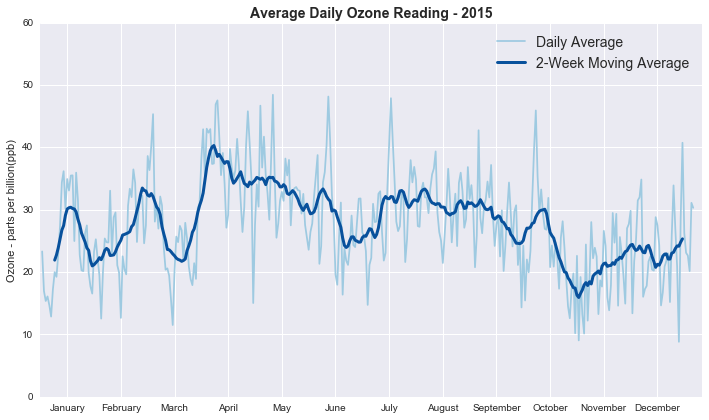

In [163]:
fig, ax = plt.subplots(figsize=(10,6))

res = pd.DataFrame(aq_15.groupby([aq_15['date'].dt.dayofyear])['all_mean'].mean())
res.index.names = ["Day"]
res = res.reset_index()

x = res['Day']
y = res['all_mean']
y_rolling = y.rolling(window=14, center=True).mean()

ax.plot(x, y, color='#9ecae1', label='Daily Average')
ax.plot(x, y_rolling, color='#08519c', linewidth=3, label='2-Week Moving Average')

ax.set_xlim(0, 370)
ax.set_ylim(0, 60)
ax.set_xticks([15 + 30 * i for i in range(12)])
ax.set_xticklabels([x[1] for x in months_choices])
ax.legend(fontsize=14)
ax.set_ylabel("Ozone - parts per billion(ppb)")

ax.set_title('Average Daily Ozone Reading - 2015', fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig("img/pol1_daily_avg_pollution_2015.png")

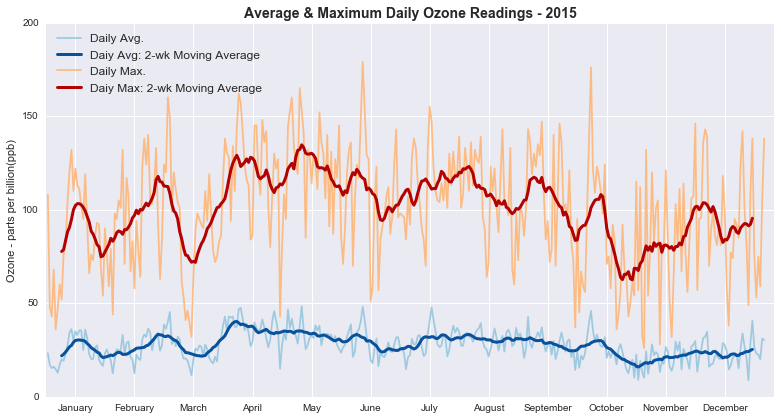

In [170]:
fig, ax = plt.subplots(figsize=(11,6))

res = pd.DataFrame(aq_15.groupby([aq_15['date'].dt.dayofyear])['all_mean'].mean())
res.index.names = ["Day"]
res = res.reset_index()

x = res['Day']
y = res['all_mean']
y_rolling = y.rolling(window=14, center=True).mean()

ax.plot(x, y, color='#9ecae1', label='Daily Avg.')
ax.plot(x, y_rolling, color='#08519c', linewidth=3, label='Daiy Avg: 2-wk Moving Average')


res = pd.DataFrame(aq_15.groupby([aq_15['date'].dt.dayofyear])['all_max'].max())
res.index.names = ["Day"]
res = res.reset_index()

x = res['Day']
y = res['all_max']
y_rolling = y.rolling(window=14, center=True).mean()

ax.plot(x, y, color='#fdbb84', label='Daily Max.')
ax.plot(x, y_rolling, color='#b30000', linewidth=3, label='Daiy Max: 2-wk Moving Average')

ax.set_xlim(0, 370)
ax.set_ylim(0, 200)
ax.set_xticks([15 + 30 * i for i in range(12)])
ax.set_xticklabels([x[1] for x in months_choices])
ax.set_ylabel("Ozone - parts per billion(ppb)")

ax.legend(fontsize=12, loc=2)

ax.set_title('Average & Maximum Daily Ozone Readings - 2015', fontsize=14, weight='bold')

plt.tight_layout()

plt.savefig("img/pol1_daily_max_pollution_2015.png")

Average 2015 vs 2016:

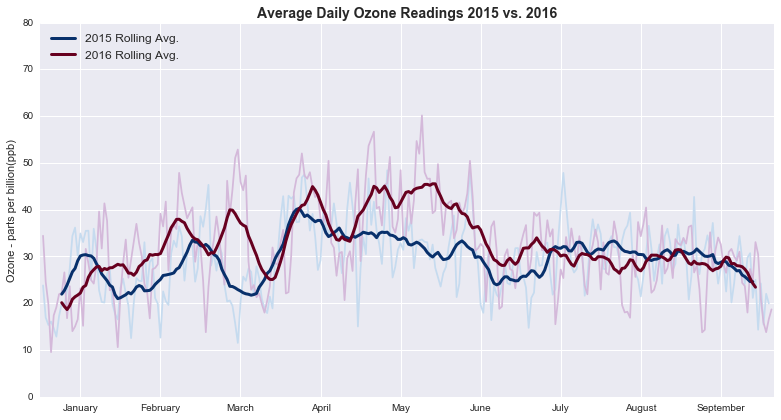

In [177]:
fig, ax = plt.subplots(figsize=(11,6))

res = pd.DataFrame(aq_15[aq_15['date'] < '2015-10-01'].groupby([aq_15['date'].dt.dayofyear])['all_mean'].mean())
res.index.names = ["Day"]
res = res.reset_index()

x = res['Day']
y = res['all_mean']
y_rolling = y.rolling(window=14, center=True).mean()

ax.plot(x, y, color='#c6dbef', label='_nolegend_')
ax.plot(x, y_rolling, color='#08306b', linewidth=3, label='2015 Rolling Avg.', zorder=10)


res = pd.DataFrame(aq_16[aq_16['date'] < '2016-10-01'].groupby([aq_16['date'].dt.dayofyear])['all_mean'].mean())
res.index.names = ["Day"]
res = res.reset_index()

x = res['Day']
y = res['all_mean']
y_rolling = y.rolling(window=14, center=True).mean()

ax.plot(x, y, color='#d4b9da', label='_nolegend_')
ax.plot(x, y_rolling, color='#67001f', linewidth=3, label='2016 Rolling Avg.', zorder=20)

ax.set_xlim(0, 275)
ax.set_ylim(0, 80)
ax.set_xticks([15 + 30 * i for i in range(9)])
ax.set_xticklabels([x[1] for x in months_choices])
ax.set_ylabel("Ozone - parts per billion(ppb)")

ax.legend(fontsize=12, loc=2)

ax.set_title('Average Daily Ozone Readings 2015 vs. 2016', fontsize=14, weight='bold')

plt.tight_layout()

plt.savefig("img/pol1_2015_v_2016.png")

#### What does pollution look like normally on an hourly basis?

In [131]:
res = pd.DataFrame(aq_15.groupby([aq_15['date'].dt.month, aq_15['date'].dt.hour])['all_mean'].mean())

res.index.names = ["Month", "Hour"]
res = res.reset_index()

In [132]:
sub = res[res['Month'] == 1]
mv = sub.max()['all_mean']
hr = sub[sub['all_mean'] == mv]['Hour']

print(mv)
print(hr)
print(hr/24)

61.4923609962
16    16
Name: Hour, dtype: int64
16    0.666667
Name: Hour, dtype: float64


In [133]:
for m in range(1, 13):
    sub = res[res['Month'] == m]
    mv = sub.max()['all_mean']
    hr = sub[sub['all_mean'] == mv]['Hour'].values[0]
    if hr == 16:
        print("{}: {}".format(m,hr))

1: 16
12: 16


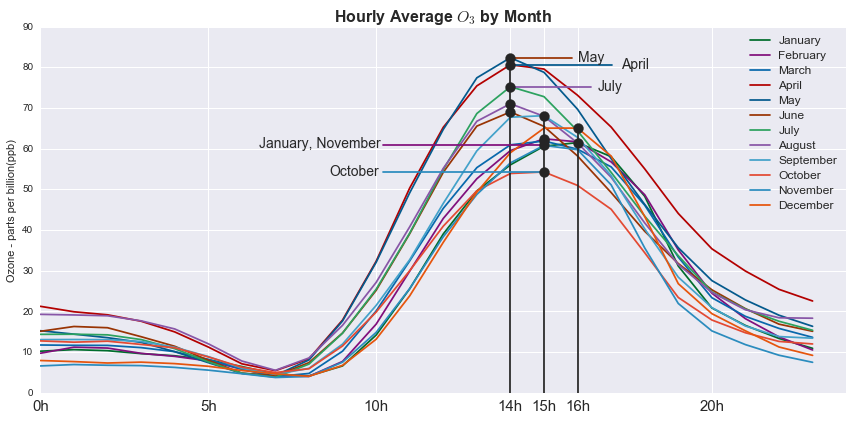

In [134]:
colors = ('#006d2c', '#810f7c', '#0868ac', '#b30000', '#045a8d', '#993404','#2ca25f', '#8856a7', '#43a2ca', '#e34a33', '#2b8cbe', '#e6550d')

fig, ax = plt.subplots(figsize=(12,6))

for m in months_choices:
    x = list(res[res['Month'] == m[0]]['Hour'])
    y = list(res[res['Month'] == m[0]]['all_mean'])

    y_max = max(y)
    x_max = x[y.index(y_max)]
    
    ax.plot(x, y, label=m[1], color=colors[m[0] - 1])
    ax.scatter(x_max, y_max, zorder=10, s=100, color='#252525')

    
ax.axvline(14, 0, 0.9, color='#252525')
ax.axvline(15, 0, 0.75, color='#252525')
ax.axvline(16, 0, 0.72, color='#252525')

ax.axhline(82.36, 0.583, 0.66, color=colors[5])
ax.text(14 + 2, 82.36 - 0.8, "May", fontsize=14)

ax.axhline(80.62, 0.583, 0.71, color=colors[4])
ax.text(14 + 3.3, 80.62 - 0.8, "April", fontsize=14)

ax.axhline(75.23, 0.583, 0.683, color=colors[7])
ax.text(14 + 2.6, 75.23 - 0.8, "July", fontsize=14)

ax.axhline(54.28, 0.625 - 0.2, 0.625, color=colors[10])
ax.text(8.6, 54.28 - 0.8, "October", fontsize=14)

ax.axhline(61, 0.625 - 0.2, 0.625, color=colors[1])
ax.text(6.5, 61 - 0.8, "January, November", fontsize=14)

ax.set_xticks([0, 5, 10, 14, 15, 16, 20])
ax.set_xticklabels(['0h', '5h', '10h', '14h', '15h', '16h', '20h'], size=15)

ax.set_ylabel("Ozone - parts per billion(ppb)")

ax.set_title(r"Hourly Average $O_3$ by Month", fontsize=16, weight='bold')
ax.set_xlim(0, 24)
ax.set_ylim(0, 90)
legend = ax.legend()
plt.setp(legend.get_texts(),fontsize=12)

plt.tight_layout()
plt.savefig("img/pol1_hourly_2015.png")

### Why was the decision taken at the end of March to impose additional restrictions?

In [135]:
len(common_stations)

33

In [136]:
# Station daily average, Jan to March

In [137]:
station_average = pd.DataFrame(columns=[2015, 2016], index=common_stations)

for s in common_stations:
    station_average.set_value(s, 2015, aq_15[aq_15['date'] < '2015-04-01 00:00:00'][s].mean(axis=0))
    station_average.set_value(s, 2016, aq_16[aq_16['date'] < '2016-04-01 00:00:00'][s].mean(axis=0))
    
station_average = station_average.dropna()
station_average['chg'] = station_average[2016] > station_average[2015]

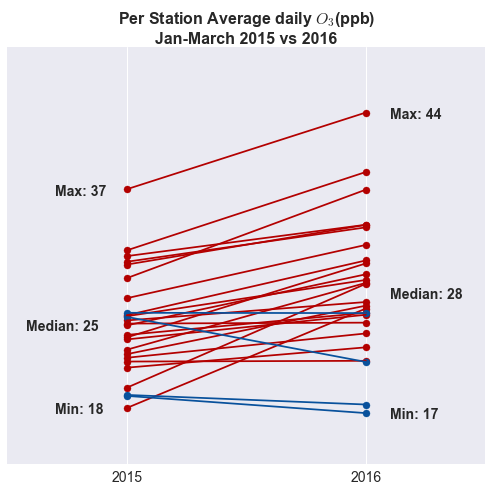

In [138]:
fig, ax = plt.subplots(figsize=(7, 7))

for x, y in zip(station_average[station_average['chg'] == 1][2015], station_average[station_average['chg'] == 1][2016]):
    ax.scatter(1, x, s=50, color='#b30000')
    ax.scatter(2, y, s=50, color='#b30000')
    ax.plot([1, 2], [x, y], color='#b30000')
    
for x, y in zip(station_average[station_average['chg'] == 0][2015], station_average[station_average['chg'] == 0][2016]):
    ax.scatter(1, x, s=50, color='#08519c')
    ax.scatter(2, y, s=50, color='#08519c')
    ax.plot([1, 2], [x, y], color='#08519c')

ax.set_xlim(0.5, 2.5)
ax.set_ylim(13, 50)
ax.set_yticks([])
ax.set_xticks([1, 2])
ax.set_xticklabels(['2015', '2016'], fontsize=14)

ax.text(0.7, station_average[2015].min() - 0.5, "Min: {:.0f}".format(station_average[2015].min()), fontsize=14, weight='bold')
ax.text(0.7, station_average[2015].max() - 0.5, "Max: {:.0f}".format(station_average[2015].max()), fontsize=14, weight='bold')
ax.text(0.58, station_average[2015].median() - 0.5, "Median: {:.0f}".format(station_average[2015].median()), fontsize=14, weight='bold')

ax.text(2.1, station_average[2016].min() - 0.5, "Min: {:.0f}".format(station_average[2016].min()), fontsize=14, weight='bold')
ax.text(2.1, station_average[2016].max() - 0.5, "Max: {:.0f}".format(station_average[2016].max()), fontsize=14, weight='bold')
ax.text(2.1, station_average[2016].median() - 0.5, "Median: {:.0f}".format(station_average[2016].median()), fontsize=14, weight='bold')

ax.set_title(r"Per Station Average daily $O_3$(ppb)" "\nJan-March 2015 vs 2016", size=16, weight='bold')

plt.tight_layout()

plt.savefig("img/pol1_q1_compare.png")

#### Days where the maximum reading was bad or worse

In [187]:
res_15 = aq_15[aq_15['date'] < '2015-04-01 00:00:00'].groupby([aq_15['date'].dt.month, aq_15['date'].dt.day])['all_max'].max()

res_15.index.names = ["Month", "Day"]
res_15 = res_15.reset_index()
res_15['bad_or_worse'] = ((res_15['all_max'] >= 96) + 1).astype(float)
res_15['Month'] = res_15['Month'].apply(lambda x: months_choices[x-1][1])

In [188]:
res_16 = aq_16[aq_16['date'] < '2016-04-01 00:00:00'].groupby([aq_16['date'].dt.month, aq_16['date'].dt.day])['all_max'].max()

res_16.index.names = ["Month", "Day"]
res_16 = res_16.reset_index()
res_16['bad_or_worse'] = ((res_16['all_max'] >= 96) + 1).astype(float)
res_16['Month'] = res_16['Month'].apply(lambda x: months_choices[x-1][1])

In [189]:
import matplotlib.gridspec as gridspec

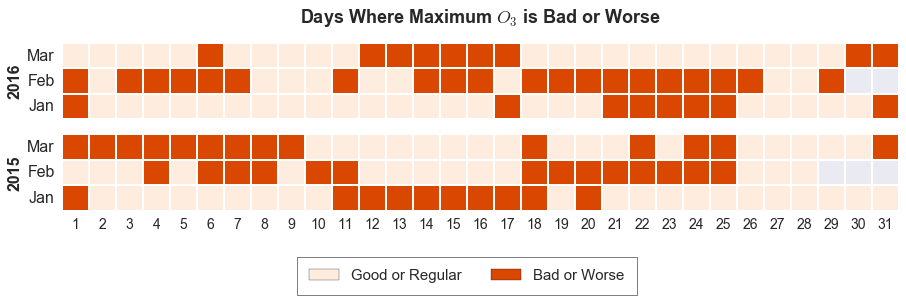

In [190]:
cmap = ('#feedde','#d94701')
fig, axes = plt.subplots(2, 1, figsize=(15, 3))
ax2 = fig.add_axes([0,0,1,1])

ax1 = axes[0]
ax3 = axes[1]


sns.heatmap(res_15.pivot(index='Day', columns='Month', values='bad_or_worse').T.reindex(["March", "February", "January"]), cmap=ListedColormap(cmap), linewidths=1, ax=ax3, cbar_ax=ax2, vmin=0, vmax=3)
sns.heatmap(res_16.pivot(index='Day', columns='Month', values='bad_or_worse').T.reindex(["March", "February", "January"]), cmap=ListedColormap(cmap), linewidths=1, ax=ax1, cbar_ax=ax2, vmin=0, vmax=3)

ax1.set_xticks([])
ax1.set_xlabel("")
ax3.set_xlabel("")
ax1.set_yticklabels(['Jan', 'Feb', 'Mar'], fontsize=16)
ax3.set_yticklabels(['Jan', 'Feb', 'Mar'], fontsize=16)
ax3.set_ylabel("2015", fontsize=16, weight='bold')
ax1.set_ylabel("2016", fontsize=16, weight='bold')

plt.setp(ax3.get_xticklabels(), fontsize=14)
ax2.set_visible(False)

p1 = patches.Rectangle((0, 0), 1, 1, fc='#feedde')
p2 = patches.Rectangle((0, 0), 1, 1, fc='#d94701')
leg = fig.legend((p1, p2), ('Good or Regular', 'Bad or Worse'), ncol=5,frameon=True, loc = 'lower center', bbox_to_anchor = (0,-0.3,1,1),
            bbox_transform = plt.gcf().transFigure, fontsize=15, borderpad=0.8)
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('white')

ttl = ax1.set_title(r"Days Where Maximum $O_3$ is Bad or Worse", size=18, weight='bold')
ttl.set_position([.5, 1.2])

plt.savefig("img/pol1_q1_compare_2.png", bbox_inches='tight')

#### What about the number of times all reading across the city exceed bad or worse?

In [191]:
def count_bad(measurements):
    count = 0.0
    for m in measurements:
        count += float(m >= 96)
    return count

In [192]:
aq_15['bad_count'] = aq_15[common_stations].apply(lambda r: count_bad(r), axis=1)
aq_16['bad_count'] = aq_16[common_stations].apply(lambda r: count_bad(r), axis=1)

In [193]:
res_15 = aq_15[aq_15['date'] < '2015-04-01 00:00:00'].groupby([aq_15['date'].dt.month, aq_15['date'].dt.day])['bad_count'].sum()
res_15.index.names = ["Month", "Day"]
res_15 = res_15.reset_index()
res_15['Month'] = res_15['Month'].apply(lambda x: months_choices[x-1][1])

In [194]:
res_16 = aq_16[aq_16['date'] < '2016-04-01 00:00:00'].groupby([aq_16['date'].dt.month, aq_16['date'].dt.day])['bad_count'].sum()
res_16.index.names = ["Month", "Day"]
res_16 = res_16.reset_index()
res_16['Month'] = res_16['Month'].apply(lambda x: months_choices[x-1][1])

In [195]:
colors = ('#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603')
def color_band(x):
    if x == 0:
        return colors[0]
    elif x <= 40:
        return colors[1]
    elif x <= 80:
        return colors[2]
    elif x <= 120:
        return colors[3]
    else:
        return colors[4]

In [196]:
res_15['color_band'] = res_15['bad_count'].apply(color_band)
res_16['color_band'] = res_16['bad_count'].apply(color_band)

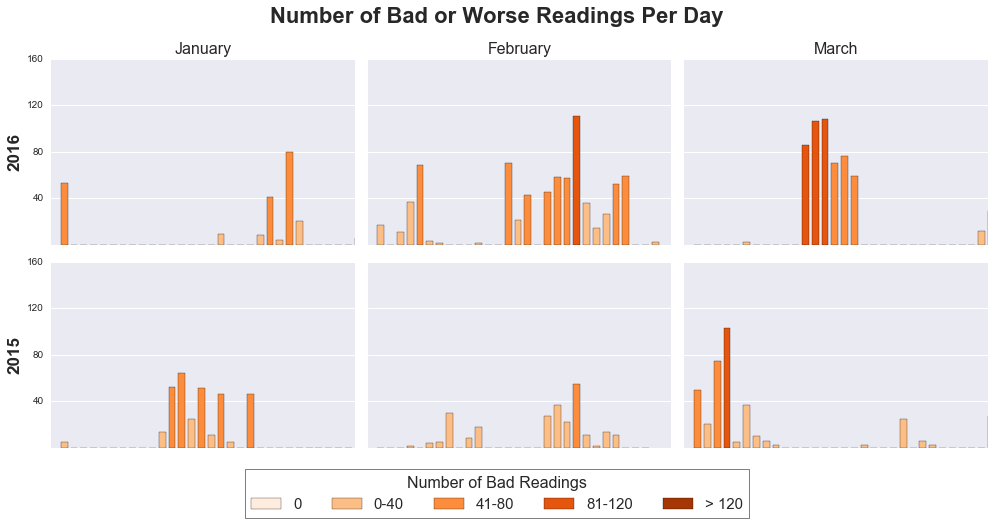

In [197]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

for i, m in enumerate((['January', 'February', 'March'])):
    x = res_15[res_15['Month'] == m]['Day']
    y = res_15[res_15['Month'] == m]['bad_count']
    c = res_15[res_15['Month'] == m]['color_band']
    axes[1][i].bar(x, y, width=0.7, color=c)
    axes[1][i].set_xlim(0, 31)
    axes[1][i].set_ylim(0, 160)
    axes[1][i].set_xticks([])
    
for i, m in enumerate(['January', 'February', 'March']):
    x = res_16[res_16['Month'] == m]['Day']
    y = res_16[res_16['Month'] == m]['bad_count']
    c = res_16[res_16['Month'] == m]['color_band']
    axes[0][i].bar(x, y, width=0.7, color=c)
    axes[0][i].set_xlim(0, 31)
    axes[0][i].set_ylim(0, 160)
    axes[0][i].set_title(m, fontsize=16)
    axes[0][i].set_xticks([])

for i in [0, 1, 2]:
    axes[0][i].set_yticks([40, 80, 120, 160])
    axes[1][i].set_yticks([40, 80, 120, 160])

for i in [1, 2]:
    axes[0][i].set_yticklabels([])
    axes[1][i].set_yticklabels([])

axes[1][0].set_ylabel("2015", fontsize=17, weight='bold')
axes[0][0].set_ylabel("2016", fontsize=17, weight='bold')

p1 = patches.Rectangle((0, 0), 1, 1, fc=colors[0])
p2 = patches.Rectangle((0, 0), 1, 1, fc=colors[1])
p3 = patches.Rectangle((0, 0), 1, 1, fc=colors[2])
p4 = patches.Rectangle((0, 0), 1, 1, fc=colors[3])
p5 = patches.Rectangle((0, 0), 1, 1, fc=colors[4])
leg = fig.legend((p1, p2, p3, p4, p5), ('0', '0-40', '41-80', '81-120', '> 120'), ncol=5,frameon=True, loc = 'lower center', bbox_to_anchor = (0,-0.15,1,1),
            bbox_transform = plt.gcf().transFigure, fontsize=15)
leg.set_title("Number of Bad Readings")
leg.get_title().set_fontsize('16')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('white')

ttl = plt.suptitle(r"Number of Bad or Worse Readings Per Day", size=22, weight='bold')
ttl.set_position([.5, 1.05])

plt.tight_layout()
plt.savefig("img/pol1_q1_compare_3.png", bbox_inches='tight')

### What happened with the additional restrictions?

1. vs. 2015
2. vs. Jan - March of 2016


In [139]:
station_average = pd.DataFrame(columns=[2015, 2016], index=common_stations)

for s in common_stations:
    station_average.set_value(s, 2015, aq_15[(aq_15['date'] < '2015-07-01 00:00:00') & (aq_15['date'] >= '2015-04-01 00:00:00')][s].mean(axis=0))
    station_average.set_value(s, 2016, aq_16[(aq_16['date'] < '2016-07-01 00:00:00') & (aq_16['date'] >= '2016-04-01 00:00:00')][s].mean(axis=0))
    
station_average = station_average.dropna()
station_average['chg'] = station_average[2016] > station_average[2015]

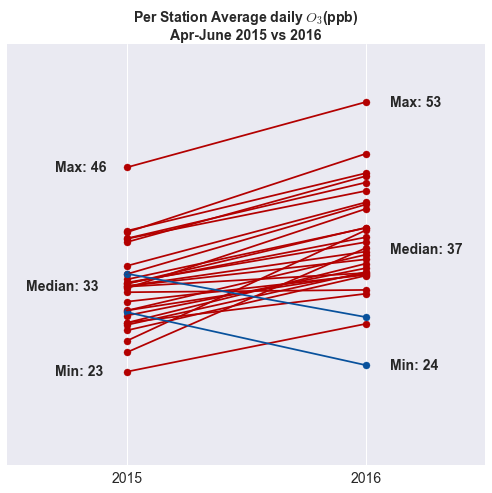

In [140]:
fig, ax = plt.subplots(figsize=(7, 7))

for x, y in zip(station_average[station_average['chg'] == 1][2015], station_average[station_average['chg'] == 1][2016]):
    ax.scatter(1, x, s=50, color='#b30000')
    ax.scatter(2, y, s=50, color='#b30000')
    ax.plot([1, 2], [x, y], color='#b30000')
    
for x, y in zip(station_average[station_average['chg'] == 0][2015], station_average[station_average['chg'] == 0][2016]):
    ax.scatter(1, x, s=50, color='#08519c')
    ax.scatter(2, y, s=50, color='#08519c')
    ax.plot([1, 2], [x, y], color='#08519c')

ax.set_xlim(0.5, 2.5)
ax.set_ylim(13, 60)
ax.set_yticks([])
ax.set_xticks([1, 2])
ax.set_xticklabels(['2015', '2016'], fontsize=14)

ax.text(0.7, station_average[2015].min() - 0.5, "Min: {:.0f}".format(station_average[2015].min()), fontsize=14, weight='bold')
ax.text(0.7, station_average[2015].max() - 0.5, "Max: {:.0f}".format(station_average[2015].max()), fontsize=14, weight='bold')
ax.text(0.58, station_average[2015].median() - 0.5, "Median: {:.0f}".format(station_average[2015].median()), fontsize=14, weight='bold')

ax.text(2.1, station_average[2016].min() - 0.5, "Min: {:.0f}".format(station_average[2016].min()), fontsize=14, weight='bold')
ax.text(2.1, station_average[2016].max() - 0.5, "Max: {:.0f}".format(station_average[2016].max()), fontsize=14, weight='bold')
ax.text(2.1, station_average[2016].median() - 0.5, "Median: {:.0f}".format(station_average[2016].median()), fontsize=14, weight='bold')

ax.set_title(r"Per Station Average daily $O_3$(ppb)" "\nApr-June 2015 vs 2016", size=14, weight='bold')

plt.tight_layout()

plt.savefig("img/pol1_q2_compare.png")

#### Days where maximum reading was bad or worse

In [151]:
res_15 = aq_15[(aq_15['date'] < '2015-07-01 00:00:00') & (aq_15['date'] >= '2015-04-01 00:00:00')].groupby([aq_15['date'].dt.month, aq_15['date'].dt.day])['all_max'].max()

res_15.index.names = ["Month", "Day"]
res_15 = res_15.reset_index()
res_15['bad_or_worse'] = ((res_15['all_max'] >= 95) + 1).astype(float)
res_15['Month'] = res_15['Month'].apply(lambda x: months_choices[x-1][1])

In [152]:
res_16 = aq_16[(aq_16['date'] < '2016-07-01 00:00:00') & (aq_16['date'] >= '2016-04-01 00:00:00')].groupby([aq_16['date'].dt.month, aq_16['date'].dt.day])['all_max'].max()

res_16.index.names = ["Month", "Day"]
res_16 = res_16.reset_index()
res_16['bad_or_worse'] = ((res_16['all_max'] >= 95) + 1).astype(float)
res_16['Month'] = res_16['Month'].apply(lambda x: months_choices[x-1][1])

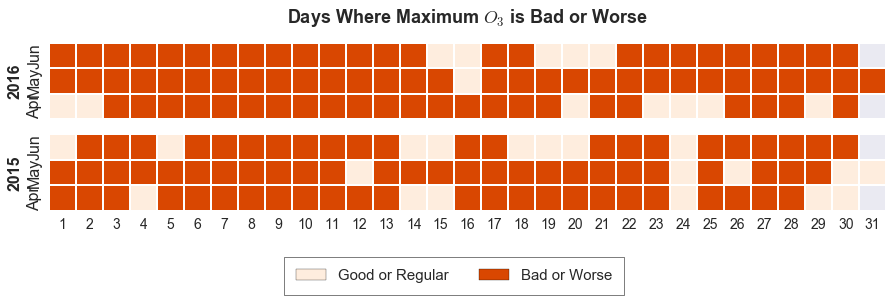

In [153]:
cmap = ('#feedde','#d94701')
fig, axes = plt.subplots(2, 1, figsize=(15, 3))
ax2 = fig.add_axes([0,0,1,1])

ax1 = axes[0]
ax3 = axes[1]


sns.heatmap(res_15.pivot(index='Day', columns='Month', values='bad_or_worse').T.reindex(["June", "May", "April"]), cmap=ListedColormap(cmap), linewidths=1, ax=ax3, cbar_ax=ax2, vmin=0, vmax=3)
sns.heatmap(res_16.pivot(index='Day', columns='Month', values='bad_or_worse').T.reindex(["June", "May", "April"]), cmap=ListedColormap(cmap), linewidths=1, ax=ax1, cbar_ax=ax2, vmin=0, vmax=3)

ax1.set_xticks([])
ax1.set_xlabel("")
ax3.set_xlabel("")
ax1.set_yticklabels(['Apr', 'May', 'Jun'], fontsize=16)
ax3.set_yticklabels(['Apr', 'May', 'Jun'], fontsize=16)
ax3.set_ylabel("2015", fontsize=16, weight='bold')
ax1.set_ylabel("2016", fontsize=16, weight='bold')

plt.setp(ax3.get_xticklabels(), fontsize=14)
ax2.set_visible(False)

p1 = patches.Rectangle((0, 0), 1, 1, fc='#feedde')
p2 = patches.Rectangle((0, 0), 1, 1, fc='#d94701')
leg = fig.legend((p1, p2), ('Good or Regular', 'Bad or Worse'), ncol=5,frameon=True, loc = 'lower center', bbox_to_anchor = (0,-0.3,1,1),
            bbox_transform = plt.gcf().transFigure, fontsize=15, borderpad=0.8)
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('white')

ttl = ax1.set_title(r"Days Where Maximum $O_3$ is Bad or Worse", size=18, weight='bold')
ttl.set_position([.5, 1.2])

plt.savefig("img/pol1_q2_compare_2.png", bbox_inches='tight')

In [206]:
res_15 = aq_15[(aq_15['date'] < '2015-07-01 00:00:00') & (aq_15['date'] >= '2015-04-01 00:00:00')].groupby([aq_15['date'].dt.month, aq_15['date'].dt.day])['bad_count'].sum()
res_15.index.names = ["Month", "Day"]
res_15 = res_15.reset_index()
res_15['Month'] = res_15['Month'].apply(lambda x: months_choices[x-1][1])

In [207]:
res_16 = aq_16[(aq_16['date'] < '2016-07-01 00:00:00') & (aq_16['date'] >= '2016-04-01 00:00:00')].groupby([aq_16['date'].dt.month, aq_16['date'].dt.day])['bad_count'].sum()
res_16.index.names = ["Month", "Day"]
res_16 = res_16.reset_index()
res_16['Month'] = res_16['Month'].apply(lambda x: months_choices[x-1][1])

In [208]:
res_15['color_band'] = res_15['bad_count'].apply(color_band)
res_16['color_band'] = res_16['bad_count'].apply(color_band)

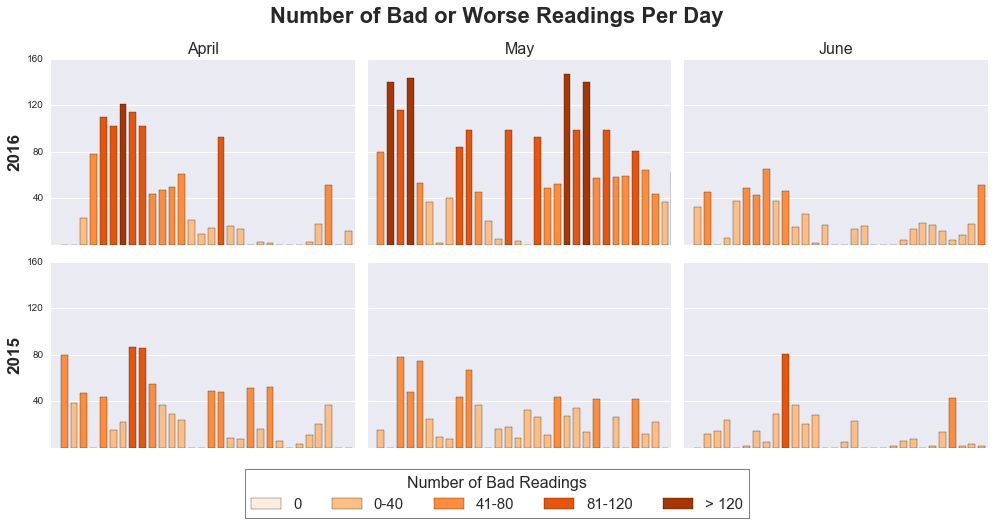

In [209]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

for i, m in enumerate((['April', 'May', 'June'])):
    x = res_15[res_15['Month'] == m]['Day']
    y = res_15[res_15['Month'] == m]['bad_count']
    c = res_15[res_15['Month'] == m]['color_band']
    axes[1][i].bar(x, y, width=0.7, color=c)
    axes[1][i].set_xlim(0, 31)
    axes[1][i].set_ylim(0, 160)
    axes[1][i].set_xticks([])
    
for i, m in enumerate(['April', 'May', 'June']):
    x = res_16[res_16['Month'] == m]['Day']
    y = res_16[res_16['Month'] == m]['bad_count']
    c = res_16[res_16['Month'] == m]['color_band']
    axes[0][i].bar(x, y, width=0.7, color=c)
    axes[0][i].set_xlim(0, 31)
    axes[0][i].set_ylim(0, 160)
    axes[0][i].set_xticks([])
    axes[0][i].set_title(m, fontsize=16)

for i in [0, 1, 2]:
    axes[0][i].set_yticks([40, 80, 120, 160])
    axes[1][i].set_yticks([40, 80, 120, 160])

for i in [1, 2]:
    axes[0][i].set_yticklabels([])
    axes[1][i].set_yticklabels([])

axes[1][0].set_ylabel("2015", fontsize=17, weight='bold')
axes[0][0].set_ylabel("2016", fontsize=17, weight='bold')

p1 = patches.Rectangle((0, 0), 1, 1, fc=colors[0])
p2 = patches.Rectangle((0, 0), 1, 1, fc=colors[1])
p3 = patches.Rectangle((0, 0), 1, 1, fc=colors[2])
p4 = patches.Rectangle((0, 0), 1, 1, fc=colors[3])
p5 = patches.Rectangle((0, 0), 1, 1, fc=colors[4])
leg = fig.legend((p1, p2, p3, p4, p5), ('0', '0-40', '41-80', '81-120', '> 120'), ncol=5,frameon=True, loc = 'lower center', bbox_to_anchor = (0,-0.15,1,1),
            bbox_transform = plt.gcf().transFigure, fontsize=15)
leg.set_title("Number of Bad Readings")
leg.get_title().set_fontsize('16')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('white')

ttl = plt.suptitle(r"Number of Bad or Worse Readings Per Day", size=22, weight='bold')
ttl.set_position([.5, 1.05])

plt.tight_layout()
plt.savefig("img/pol1_q2_compare_3.png", bbox_inches='tight')

In [210]:
res_15 = aq_15[(aq_15['date'] < '2015-10-01 00:00:00') & (aq_15['date'] >= '2015-07-01 00:00:00')].groupby([aq_15['date'].dt.month, aq_15['date'].dt.day])['bad_count'].sum()
res_15.index.names = ["Month", "Day"]
res_15 = res_15.reset_index()
res_15['Month'] = res_15['Month'].apply(lambda x: months_choices[x-1][1])

In [211]:
res_16 = aq_16[(aq_16['date'] < '2016-10-01 00:00:00') & (aq_16['date'] >= '2016-07-01 00:00:00')].groupby([aq_16['date'].dt.month, aq_16['date'].dt.day])['bad_count'].sum()
res_16.index.names = ["Month", "Day"]
res_16 = res_16.reset_index()
res_16['Month'] = res_16['Month'].apply(lambda x: months_choices[x-1][1])

In [212]:
res_15['color_band'] = res_15['bad_count'].apply(color_band)
res_16['color_band'] = res_16['bad_count'].apply(color_band)

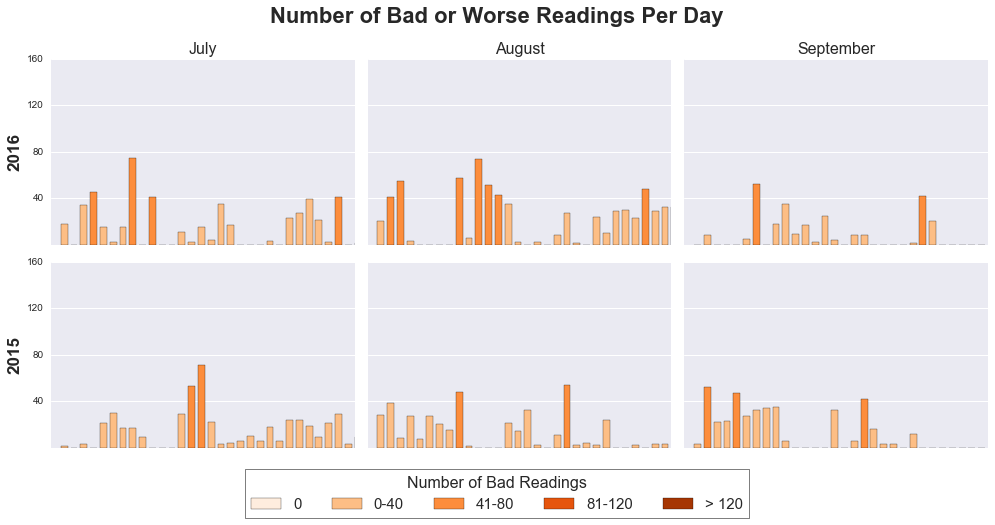

In [213]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

for i, m in enumerate((['July', 'August', 'September'])):
    x = res_15[res_15['Month'] == m]['Day']
    y = res_15[res_15['Month'] == m]['bad_count']
    c = res_15[res_15['Month'] == m]['color_band']
    axes[1][i].bar(x, y, width=0.7, color=c)
    axes[1][i].set_xlim(0, 31)
    axes[1][i].set_ylim(0, 160)
    axes[1][i].set_xticks([])
    
for i, m in enumerate(['July', 'August', 'September']):
    x = res_16[res_16['Month'] == m]['Day']
    y = res_16[res_16['Month'] == m]['bad_count']
    c = res_16[res_16['Month'] == m]['color_band']
    axes[0][i].bar(x, y, width=0.7, color=c)
    axes[0][i].set_xlim(0, 31)
    axes[0][i].set_ylim(0, 160)
    axes[0][i].set_title(m, fontsize=16)
    axes[0][i].set_xticks([])

for i in [0, 1, 2]:
    axes[0][i].set_yticks([40, 80, 120, 160])
    axes[1][i].set_yticks([40, 80, 120, 160])

for i in [1, 2]:
    axes[0][i].set_yticklabels([])
    axes[1][i].set_yticklabels([])

axes[1][0].set_ylabel("2015", fontsize=17, weight='bold')
axes[0][0].set_ylabel("2016", fontsize=17, weight='bold')

p1 = patches.Rectangle((0, 0), 1, 1, fc=colors[0])
p2 = patches.Rectangle((0, 0), 1, 1, fc=colors[1])
p3 = patches.Rectangle((0, 0), 1, 1, fc=colors[2])
p4 = patches.Rectangle((0, 0), 1, 1, fc=colors[3])
p5 = patches.Rectangle((0, 0), 1, 1, fc=colors[4])
leg = fig.legend((p1, p2, p3, p4, p5), ('0', '0-40', '41-80', '81-120', '> 120'), ncol=5,frameon=True, loc = 'lower center', bbox_to_anchor = (0,-0.15,1,1),
            bbox_transform = plt.gcf().transFigure, fontsize=15)
leg.set_title("Number of Bad Readings")
leg.get_title().set_fontsize('16')
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('white')

ttl = plt.suptitle(r"Number of Bad or Worse Readings Per Day", size=22, weight='bold')
ttl.set_position([.5, 1.05])

plt.tight_layout()
plt.savefig("img/pol1_q3_compare_1.png", bbox_inches='tight')

## Air Pressure

In [25]:
pa_16 = pd.read_json('data/cleaned/PA_2016_sm_PA.json').sort_values(by='date')
pa_16 = pa_16.drop('MON', axis=1)
pa_16['date'] = pa_16['date'].apply(change_hour)
pa_16['date'] = pd.to_datetime(pa_16['date'])
cols = pa_16.columns.tolist()
cols.remove('date')
pa_16[cols] = pa_16[cols].apply(pd.to_numeric)
pa_16['avg_pa'] = pa_16[cols].mean(axis=1)

In [26]:
pa_15 = pd.read_json('data/cleaned/PA_2015_sm_PA.json').sort_values(by='date')
pa_15 = pa_15.drop('MON', axis=1)
pa_15['date'] = pa_15['date'].apply(change_hour)
pa_15['date'] = pd.to_datetime(pa_15['date'])
cols = pa_15.columns.tolist()
cols.remove('date')
pa_15[cols] = pa_15[cols].apply(pd.to_numeric)
pa_15['avg_pa'] = pa_15[cols].mean(axis=1)

## Humidity

In [27]:
rh_16 = pd.read_json('data/cleaned/meteorología_2016_sm_RH.json').sort_values(by='date')
rh_16['date'] = rh_16['date'].apply(change_hour)
rh_16['date'] = pd.to_datetime(rh_16['date'])
cols = rh_16.columns.tolist()
cols.remove('date')
rh_16[cols] = rh_16[cols].apply(pd.to_numeric)
rh_16['avg_rh'] = rh_16[cols].mean(axis=1)

In [28]:
rh_15 = pd.read_json('data/cleaned/meteorología_2015_sm_RH.json').sort_values(by='date')
rh_15['date'] = rh_15['date'].apply(change_hour)
rh_15['date'] = pd.to_datetime(rh_15['date'])
cols = rh_15.columns.tolist()
cols.remove('date')
rh_15[cols] = rh_15[cols].apply(pd.to_numeric)
rh_15['avg_rh'] = rh_15[cols].mean(axis=1)

## Temperature

In [29]:
tmp_16 = pd.read_json('data/cleaned/meteorología_2016_sm_TMP.json').sort_values(by='date')
tmp_16['date'] = tmp_16['date'].apply(change_hour)
tmp_16['date'] = pd.to_datetime(tmp_16['date'])
cols = tmp_16.columns.tolist()
cols.remove('date')
tmp_16[cols] = tmp_16[cols].apply(pd.to_numeric)
tmp_16['avg_tmp'] = tmp_16[cols].mean(axis=1)

In [30]:
tmp_15 = pd.read_json('data/cleaned/meteorología_2015_sm_TMP.json').sort_values(by='date')
tmp_15['date'] = tmp_15['date'].apply(change_hour)
tmp_15['date'] = pd.to_datetime(tmp_15['date'])
cols = tmp_15.columns.tolist()
cols.remove('date')
tmp_15[cols] = tmp_15[cols].apply(pd.to_numeric)
tmp_15['avg_tmp'] = tmp_15[cols].mean(axis=1)

## Wind Speed

In [31]:
wsp_16 = pd.read_json('data/cleaned/meteorología_2016_sm_WSP.json').sort_values(by='date')
wsp_16['date'] = wsp_16['date'].apply(change_hour)
wsp_16['date'] = pd.to_datetime(wsp_16['date'])
cols = wsp_16.columns.tolist()
cols.remove('date')
wsp_16[cols] = wsp_16[cols].apply(pd.to_numeric)
wsp_16['avg_wsp'] = wsp_16[cols].mean(axis=1)

In [32]:
wsp_15 = pd.read_json('data/cleaned/meteorología_2015_sm_WSP.json').sort_values(by='date')
wsp_15['date'] = wsp_15['date'].apply(change_hour)
wsp_15['date'] = pd.to_datetime(wsp_15['date'])
cols = wsp_15.columns.tolist()
cols.remove('date')
wsp_15[cols] = wsp_15[cols].apply(pd.to_numeric)
wsp_15['avg_wsp'] = wsp_15[cols].mean(axis=1)

In [33]:
joint = aq_16[['date', 'all_mean']].merge(pa_16[['date', 'avg_pa']], how='inner', on='date')
joint = joint.merge(rh_16[['date', 'avg_rh']], how='inner', on='date')
joint = joint.merge(tmp_16[['date', 'avg_tmp']], how='inner', on='date')
joint = joint.merge(wsp_16[['date', 'avg_wsp']], how='inner', on='date')

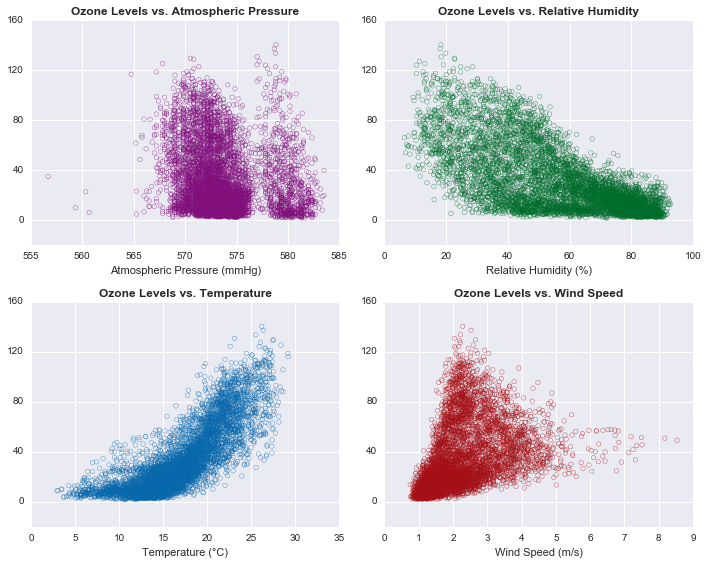

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

axes[0][0].scatter(joint['avg_pa'], joint['all_mean'], facecolors='none', edgecolors='#810f7c')
axes[0][0].set_title("Ozone Levels vs. Atmospheric Pressure", weight='bold')
axes[0][0].set_xlabel("Atmospheric Pressure (mmHg)")

axes[0][1].scatter(joint['avg_rh'], joint['all_mean'], facecolors='none', edgecolors='#006d2c')
axes[0][1].set_title("Ozone Levels vs. Relative Humidity", weight='bold')
axes[0][1].set_xlabel("Relative Humidity (%)")

axes[1][0].scatter(joint['avg_tmp'], joint['all_mean'], facecolors='none', edgecolors='#0868ac')
axes[1][0].set_title("Ozone Levels vs. Temperature", weight='bold')
axes[1][0].set_xlabel("Temperature (°C)")

axes[1][1].scatter(joint['avg_wsp'], joint['all_mean'], facecolors='none', edgecolors='#a50f15')
axes[1][1].set_title("Ozone Levels vs. Wind Speed", weight='bold')
axes[1][1].set_xlabel("Wind Speed (m/s)")


for i, j in itertools.product([0, 1], [0, 1]):
    axes[i][j].set_yticks([0, 40, 80, 120, 160])

plt.tight_layout()
    
plt.savefig("img/pol1_weather.png", bbox_inches='tight')

In [88]:
frames = {'pa': pa_15, 'rh': rh_15, 'tmp': tmp_15, 'wsp': wsp_15}

res_15 = pd.DataFrame([i for i in range(1, 182)], columns=['day'])
for m in ['pa', 'rh', 'tmp', 'wsp']:
    f = frames[m]
    res = pd.DataFrame(f.groupby([f[f['date'] < '2015-07-01']['date'].dt.dayofyear])["avg_{}".format(m)].mean()).values
    res_15["avg_{}".format(m)] = res
    res_15[m] = res_15["avg_{}".format(m)].rolling(window=14, center=True).mean()

In [89]:
frames = {'pa': pa_16, 'rh': rh_16, 'tmp': tmp_16, 'wsp': wsp_16}

res_16 = pd.DataFrame([i for i in range(1, 183)], columns=['day'])
for m in ['pa', 'rh', 'tmp', 'wsp']:
    f = frames[m]
    res = pd.DataFrame(f.groupby([f[f['date'] < '2016-07-01']['date'].dt.dayofyear])["avg_{}".format(m)].mean()).values
    res_16["avg_{}".format(m)] = res
    res_16[m] = res_16["avg_{}".format(m)].rolling(window=14, center=True).mean()

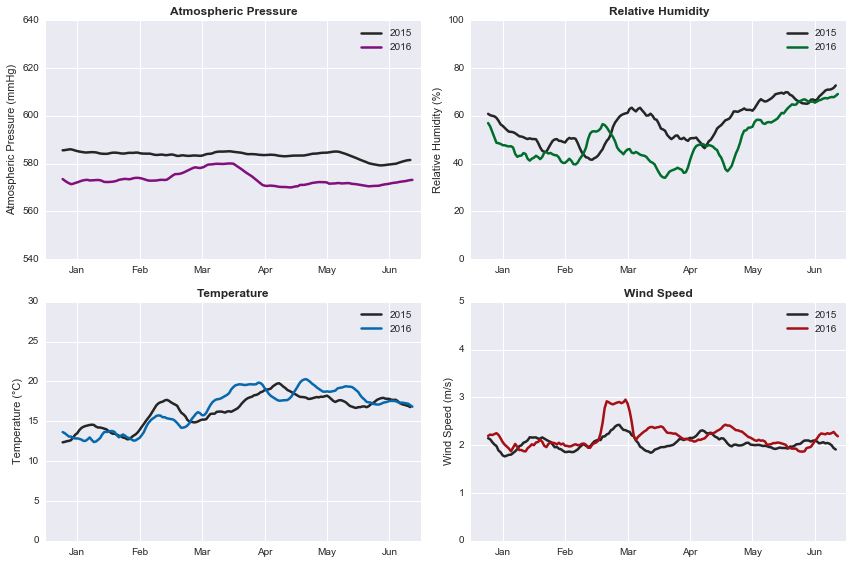

In [147]:
colors = ('#810f7c', '#006d2c', '#0868ac', '#a50f15')
ylabels = ("Atmospheric Pressure (mmHg)", "Relative Humidity (%)", "Temperature (°C)", "Wind Speed (m/s)")
titles = ("Atmospheric Pressure", "Relative Humidity", "Temperature", "Wind Speed")
fig, axes = plt.subplots(2, 2, figsize=(12,8))

for i, (ax, m) in enumerate(zip(axes.reshape(-1), ['pa', 'rh', 'tmp', 'wsp'])):
    ax.plot(res_15['day'], res_15[m], color='#252525', linewidth=2.5, label=2015)
    ax.plot(res_16['day'], res_16[m], color=colors[i], linewidth=2.5, label=2016)
    ax.set_ylabel(ylabels[i])
    ax.set_title(titles[i], weight='bold')
    ax.set_xticks([15, 45, 75, 105, 135, 165])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
    ax.legend()
    
axes[0][0].set_ylim(540, 640)
axes[0][1].set_ylim(0, 100)
axes[1][0].set_ylim(0, 30)
axes[1][1].set_ylim(0, 5)

plt.tight_layout()
    
plt.savefig("img/pol1_weather_2.png", bbox_inches='tight')